# Plots for logistic regression theory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio
import matplotlib.lines

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPERIMENT_NAME = 'logistic_regression_theory_empirical'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.6, 2.0)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPERIMENT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(
    experiment.experiment_id
)
runs = runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
runs['params.data_dim'] = runs['params.data_dim'].astype(int)
runs['params.train_attack_epsilon'] = runs['params.train_attack_epsilon'].astype(np.float)
runs['params.test_attack_epsilon'] = runs['params.test_attack_epsilon'].astype(np.float)
runs['params.l2_lambda'] = runs['params.l2_lambda'].astype(np.float)
runs = runs.sort_values(['params.data_dim', 'params.l2_lambda'])
print('Loaded', len(runs), 'runs')
assert runs['status'].eq('FINISHED').all()

Loaded 64 runs


## Plots

In [8]:
std_risk_color_idx = 0
robust_risk_color_idx = 1
data_dims = runs['params.data_dim'].unique()
num_samples, = runs['params.data_num_train_samples'].astype(int).unique()
assert runs['params.train_consistent_attacks'].eq('True').all()

l2_lambdas_ls = {
    0.0: ('-', 'D'),
    1.0: ('--', 'x')
}

lambda_label_map = {
    0.0: 'interpolating',
    1.0: 'regularized'
}

epsilons = (0.05, 0.02)

SCATTER_LEGEND = False


In [9]:
theory_predictions = {epsilon: dict() for epsilon in epsilons}
theory_gammas = {epsilon: dict() for epsilon in epsilons}
for epsilon in epsilons:
    for l2_lambda in l2_lambdas_ls.keys():
        file_path = f'./theory_predictions_eps{epsilon:.2f}_lambda{l2_lambda:.5f}.csv'
        raw_predictions = pd.read_csv(file_path, sep=',', header=0).sort_values('gamma')
        theory_predictions[epsilon][l2_lambda] = raw_predictions.apply(
            lambda row: ir.closed_form.logistic_regression_asymptotic_risks_linf(row['orth_l2_norm'], row['par_l2_norm'], row['proj_l1_norm'], epsilon),
            axis=1,
            result_type='expand'
        ).values
        theory_gammas[epsilon][l2_lambda] = raw_predictions['gamma']


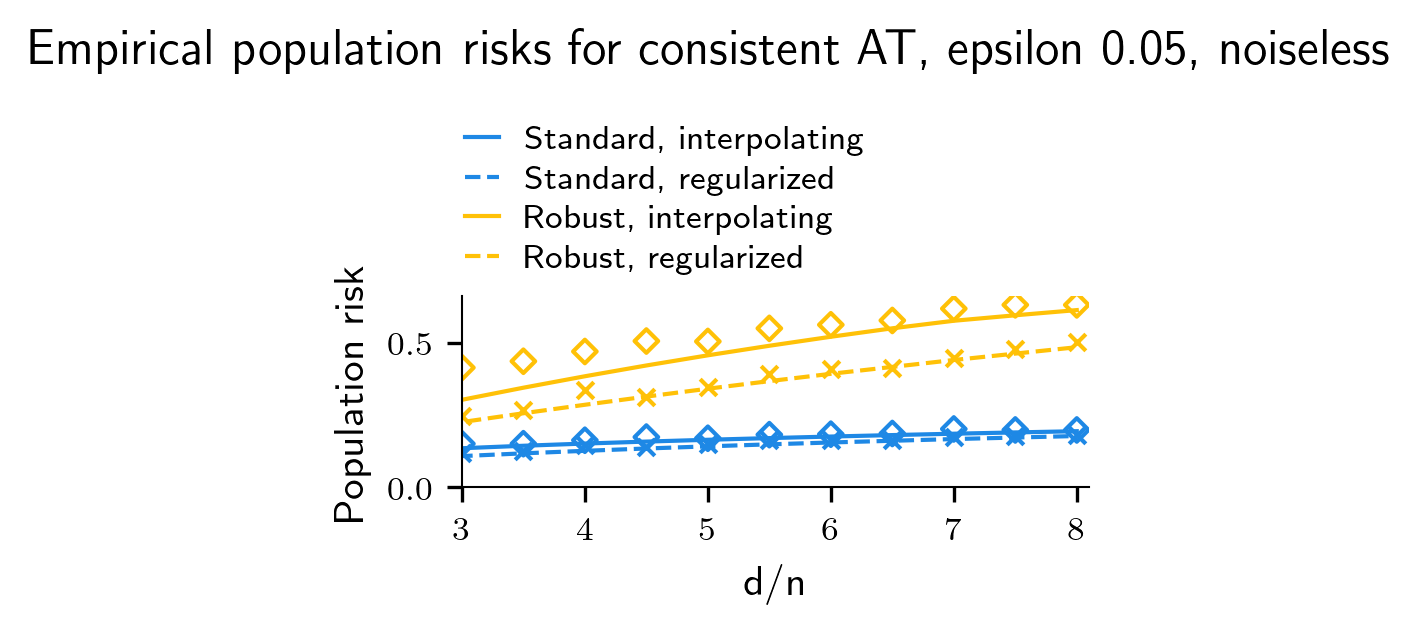

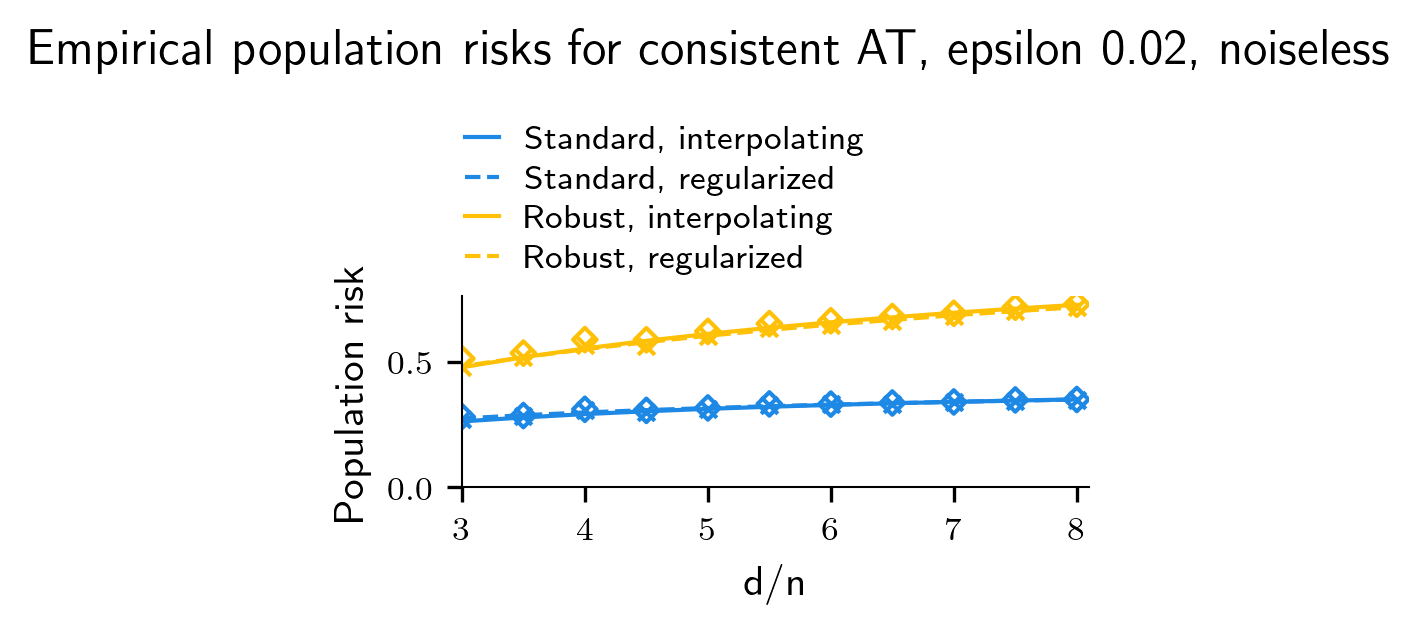

In [10]:
legend_font_size = LEGEND_FONT_SIZE

for epsilon in epsilons:
    empirical_runs = runs[runs['params.test_attack_epsilon'] == epsilon]

    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    # Standard risk
    for l2_lambda, (line_style, empirical_marker) in l2_lambdas_ls.items():
        # Theoretical predictions
        ax.plot(
            theory_gammas[epsilon][l2_lambda],
            theory_predictions[epsilon][l2_lambda][:, 0],
            label=fr'Standard, {lambda_label_map[l2_lambda]}',
            c=f'C{std_risk_color_idx}',
            ls=line_style,
            zorder=1
        )
        
        # Empirical validation
        current_runs = empirical_runs[empirical_runs['params.l2_lambda'] == l2_lambda]
        ax.scatter(
            current_runs['params.data_dim'] / float(num_samples),
            current_runs['metrics.true_std_risk'],
            label=f'Standard, {lambda_label_map[l2_lambda]}' if SCATTER_LEGEND else None,
            edgecolors=f'C{std_risk_color_idx}',
            facecolors='none' if empirical_marker != 'x' else None,
            marker=empirical_marker,
            zorder=2,
            **ir.plots.matplotlib_scatter_marker_settings()
        )
    
    # Robust risk
    for l2_lambda, (line_style, empirical_marker) in l2_lambdas_ls.items():
        # Theoretical predictions
        ax.plot(
            theory_gammas[epsilon][l2_lambda],
            theory_predictions[epsilon][l2_lambda][:, 1],
            label=fr'Robust, {lambda_label_map[l2_lambda]}',
            c=f'C{robust_risk_color_idx}',
            ls=line_style,
            zorder=1
        )
        
        # Empirical validation
        current_runs = empirical_runs[empirical_runs['params.l2_lambda'] == l2_lambda]
        ax.scatter(
            current_runs['params.data_dim'] / float(num_samples),
            current_runs['metrics.true_robust_risk'],
            label=f'Robust, {lambda_label_map[l2_lambda]}' if SCATTER_LEGEND else None,
            edgecolors=f'C{robust_risk_color_idx}',
            facecolors='none' if empirical_marker != 'x' else None,
            marker=empirical_marker,
            zorder=2,
            **ir.plots.matplotlib_scatter_marker_settings()
        )


    ax.set_xlabel('d/n')
    ax.set_ylabel('Population risk')
    ax.set_ylim(bottom=0)
    ax.set_xlim(3, 8.1)
    ax.set_xticks(tuple(range(3, 8 + 1)))

    legend_loc = (0.0, 1.1)
    ax.legend(fontsize=LEGEND_FONT_SIZE, loc=legend_loc)

    if SHOW_TITLES:
        fig.suptitle(f'Empirical population risks for consistent AT, epsilon {epsilon}, noiseless')

    export_fig(fig, f'logreg_theory_eps_{epsilon:.2f}.pdf')
    plt.show()
